In [1]:
from csv import reader
import pandas as pd
import numpy as np

import random
import sys

import os
import shutil

# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import time

import multiprocessing
from functools import partial

# genetic algorithm search of the one max optimization problem
from numpy.random import randint
# from numpy.random import rand


import Scripts.LevenClustering as levenClustering
import Scripts.SeqCleaning as seqCleaning
import Scripts.GenFunction as genFunction
import Scripts.GAFunctions as GAfunctions
import Scripts.StatFitness as statFitness


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

output = "Puzzles_Output"
# file = ['00 Result/SelectionF15/puzzle_1.csv', '00 Result/SelectionS16/puzzle_1.csv']
file = ['Puzzles_CSV/Puzzle_1.csv']

In [3]:
import numpy as np
outliers = []
def detect_outliers_zscore(data):
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in range(len(data)):
        z_score = (data[i]-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code

In [4]:
### GA parameters

job_id = "standard"
n_trials = 2 # define the total trials
n_iter = 4+1 # define the total generations
n_pop = 2 # define the population size
n_bits = 16 # bits
label_mask = 8 # split the R and T
CPU_power = 4

measure = 'Silhouette'
asc = False
n_clusters = 3

# measure = 'AIC'
# asc = True

# job_id = os.environ["SLURM_JOB_ID"]
# CPU_power = int(sys.argv[1])
# n_clusters = int(sys.argv[2])
# measure = sys.argv[3]
# asc = sys.argv[4]

# asc = asc.lower()
# if asc in ["true", "t"]:
#     asc = True
# elif asc in ["false", "f"]:
#     asc = False

# n_trials = int(sys.argv[5])
# n_iter = int(sys.argv[6])+1
# n_pop = int(sys.argv[7])
# n_bits = int(sys.argv[8])
# label_mask = int(sys.argv[9])


r_cross = 0.5 # crossover rate
r_mut = 1.0 / float(n_bits) # mutation rate

print("Cluster: ", n_clusters)
print("Measurement: ", measure)
print("trial: ", n_trials)
print("generation: ", n_iter)
print("population: ", n_pop)
print("total_bits: ", n_bits)
print("bits_mask: ", label_mask)


Cluster:  3
Measurement:  Silhouette
trial:  2
generation:  5
population:  2
total_bits:  16
bits_mask:  8


In [5]:
col_names = ['File Path', 'sequence', 'steps', 'time_spent']
df = pd.DataFrame(columns = col_names)

file_path = []
sequence = []
steps = []
time_spent = []

pop_cache = {}

if __name__ == "__main__":

    for f in file:

        with open(f, 'r') as read_obj:
            csv_reader = reader(read_obj)
            header = next(csv_reader)

            if header != None:
                for row in csv_reader:
                    file_path.append(row[0])
                    sequence.append(row[6])
                    steps.append(row[3])
                    time_spent.append(row[5])

    df['File Path'] = file_path
    df['sequence'] = sequence
    df['steps'] = steps
    df['time_spent'] = time_spent

    print("Total Rows for original: ", len(df.index))
    

    df['Extra_Steps'] = (df['steps'].astype(int))-16
    sample_outliers = detect_outliers_zscore(df['Extra_Steps'])
    update_df = df.copy()
    update_df = df.drop(sample_outliers)
    update_df = update_df.reset_index(drop=True)
    
    
    ###new_code
    num_R = genFunction.count_label(update_df, 'R')
    update_df['num_R'] = num_R
    num_T = genFunction.count_label(update_df, 'T')
    update_df['num_T'] = num_T
    
    #################

    
#     genFunction.label_info(update_df, 'R', 1)
    
    
    col_names = ['Trial', 'Generation', 'Population', 'Pattern', 'R', 'T', 'Silhouette', 'AIC', 'Dispersion', 'R_squared']
    for i in range(1, n_clusters+1):
        col_names.append('Total_cluster_{}'.format(i))
        
    df_result = pd.DataFrame(columns = col_names)
    
    row_num = 0
    
    print("Total Rows for after elimination outliers: ", len(update_df.index))
    
    for trial in range(n_trials):
        
        df_1 = update_df.copy()
    
        # initial population of random bitstring
        pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
        # assign the first combination as the best
#         best = pop[0]
#         _, best_eval, best_eval_aic, _, _ = genFunction.calc_score(df_1, pop_cache, label_mask, pop[0])
        
        
        ts2_before = time.time()

        
        print("Trial", trial+1, ":")

        for gen in range(n_iter):

            scores = []
            row_num += 1

            ts_before = time.time()


            pool = multiprocessing.Pool(CPU_power)
            combined_args = partial(genFunction.calc_score, df_1, pop_cache, label_mask, n_clusters)
            result = pool.map(func=combined_args, iterable=pop)
            pool.close()
            pool.join()
                
            col_names = ['Pattern', 'Silhouette', 'AIC', 'Dispersion', 'R_squared']                
            df_output = pd.DataFrame(columns = col_names)


            for i in range(len(result)):
                pop_cache[result[i][0]] = list(result[i][1:])
            
                df_output.loc[i, "Pattern"] = genFunction.convert_to_binary(result[i][0], n_bits)
                df_output.loc[i, "Silhouette"] = result[i][1]
                df_output.loc[i, "AIC"] = result[i][2]
                df_output.loc[i, "Dispersion"] = result[i][3]
                df_output.loc[i, "R_squared"] = result[i][4]
                
            
            df_output = df_output.sort_values(by=measure, ascending=asc)
            pop = list(df_output["Pattern"].head(n_pop))
            scores = list(df_output[measure].head(n_pop))
            
        
            # assign the first combination as the best
            best = pop[0]
            best_eval = scores[0]
            
            
            for i in range(n_pop):
            ### Get the best combination and score
                if asc:
                    if scores[i] <= best_eval:
                        best, best_eval = pop[i], scores[i]
                
                else:
                    if scores[i] >= best_eval:
                        best, best_eval = pop[i], scores[i]



            ts_after = time.time()
            ts = ts_after - ts_before
            
            best_dec = genFunction.convert_to_decimal(best)

            print(f'Gen: {gen}, R = {best[:label_mask]}, T = {best[label_mask:]}, SS: {round(pop_cache.get(best_dec)[0], 4)}, AIC: {round(pop_cache.get(best_dec)[1], 4)}, Disp: {round(pop_cache.get(best_dec)[2], 4)}, Rsq: {round(pop_cache.get(best_dec)[3], 4)}, Time Taken: {round(ts, 2)}s, n=3')
#             print(f'Silhouette: {pop_cache.get(best_dec)[0]}')
#             print(f'AIC: {pop_cache.get(best_dec)[1]}')
#             print(f'Dispersion: {pop_cache.get(best_dec)[2]}')
#             print(f'R_squared: {pop_cache.get(best_dec)[3]}')

            ### Storing the result-----------------------
            
            
            
            df_result.loc[row_num, 'Trial'] = trial+1
            df_result.loc[row_num, 'Generation'] = gen
            df_result.loc[row_num, 'Population'] = len(pop)
            df_result.loc[row_num, 'Pattern'] = best
            df_result.loc[row_num, 'R'] = best[:label_mask]
            df_result.loc[row_num, 'T'] = best[label_mask:]
            df_result.loc[row_num, 'Silhouette'] = pop_cache.get(best_dec)[0]
            df_result.loc[row_num, 'AIC'] = pop_cache.get(best_dec)[1]
            df_result.loc[row_num, 'Dispersion'] = pop_cache.get(best_dec)[2]
            df_result.loc[row_num, 'R_squared'] = pop_cache.get(best_dec)[3]
            
            for j in range(1, n_clusters+1):
                df_result.loc[row_num, 'Total_cluster_{}'.format(j)] = pop_cache.get(best_dec)[4][j-1]
            
            

            ### GA Operations----------------------------
            if (gen+1) == n_iter:
                break
            
            
            # select parents
            selected = [GAfunctions.selection(pop, scores, asc) for _ in range(n_pop)]  

            children = []

            for i in range(0, n_pop, 2):
                # get selected parents in pairs
                p1, p2 = selected[i], selected[i+1]

                for c in GAfunctions.crossover(p1, p2, r_cross):

                    # mutation
                    GAfunctions.mutation(c, r_mut)

                    # store for next generation
                    children.append(c)

            # replace population
            pop = pop + children

            ### --------------------------------------------

        ts2_after = time.time()
        ts2 = ts2_after - ts2_before
        

        print("Done--------------------------------------", ts2)


    

Total Rows for original:  294
Total Rows for after elimination outliers:  286
Trial 1 :
Gen: 0, R = [1, 1, 1, 1, 1, 0, 1, 0], T = [0, 1, 0, 1, 0, 0, 0, 0], SS: 0.3226, AIC: 872.984, Disp: 0.958, Rsq: 0.8828, Time Taken: 46.45s, n=3
Gen: 1, R = [1, 1, 1, 1, 1, 0, 1, 0], T = [0, 1, 0, 1, 0, 0, 0, 0], SS: 0.3226, AIC: 872.984, Disp: 0.958, Rsq: 0.8828, Time Taken: 1.29s, n=3
Gen: 2, R = [1, 1, 1, 1, 1, 0, 0, 0], T = [0, 1, 0, 1, 0, 0, 0, 0], SS: 0.3639, AIC: 913.4386, Disp: 1.1496, Rsq: 0.8193, Time Taken: 46.88s, n=3
Gen: 3, R = [1, 1, 1, 1, 1, 0, 0, 0], T = [0, 1, 0, 1, 0, 0, 0, 0], SS: 0.3639, AIC: 913.4386, Disp: 1.1496, Rsq: 0.8193, Time Taken: 52.64s, n=3
Gen: 4, R = [1, 1, 1, 1, 1, 0, 0, 0], T = [0, 1, 0, 1, 0, 0, 0, 0], SS: 0.3639, AIC: 913.4386, Disp: 1.1496, Rsq: 0.8193, Time Taken: 50.87s, n=3
Done-------------------------------------- 198.14651203155518
Trial 2 :
Gen: 0, R = [1, 0, 0, 1, 1, 0, 0, 0], T = [0, 1, 0, 1, 1, 0, 0, 1], SS: 0.397, AIC: 943.8405, Disp: 1.3149, Rsq: 0.

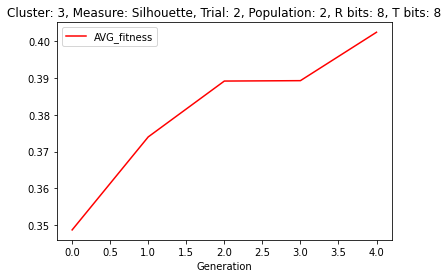

In [6]:
if measure == 'Silhouette':
    another_measure = 'AIC'
elif measure == 'AIC':
    another_measure = 'Silhouette'


col_names = ['Generation', 'Population', 'AVG_fitness', another_measure, 'Dispersion', 'RSQ']
ga_result = pd.DataFrame(columns = col_names)

avg_score = 0

for i in range(n_iter):
    ga_result.loc[i, 'Population'] = n_pop
    ga_result.loc[i, 'Generation'] = i
    
    seq = list(df_result.loc[df_result['Generation'] == i, measure])
    avg_score = sum(seq)/len(seq)
    ga_result.loc[i, 'AVG_fitness'] = avg_score
    
    seq = list(df_result.loc[df_result['Generation'] == i, another_measure])
    avg_score = sum(seq)/len(seq)
    ga_result.loc[i, another_measure] = avg_score
    
    seq = list(df_result.loc[df_result['Generation'] == i, "Dispersion"])
    avg_score = sum(seq)/len(seq)
    ga_result.loc[i, 'Dispersion'] = avg_score
    
    seq = list(df_result.loc[df_result['Generation'] == i, "R_squared"])
    avg_score = sum(seq)/len(seq)    
    ga_result.loc[i, 'RSQ'] = avg_score
    
max_id = pd.to_numeric(df_result[measure]).idxmax()
best = df_result.loc[max_id, "Pattern"]
    
df_final = genFunction.dataset_cleaning(df_1, label_mask, best)
df_final, _ = GAfunctions.fitness(df_final, n_clusters, 0)

ga_result.plot(kind='line',x='Generation',y='AVG_fitness',color='red')
plt.title("Cluster: {}, Measure: {}, Trial: {}, Population: {}, R bits: {}, T bits: {}".format(n_clusters, measure, n_trials, n_pop, label_mask, (n_bits-label_mask)))
plt.savefig('{}/{}_output.png'.format(output, job_id))
plt.show()

df_result.to_csv('{}/{}_out.csv'.format(output, job_id), index=False)  
df_final.to_csv('{}/{}_best_final_output.csv'.format(output, job_id), index=False) 

ga_result.to_csv('{}/{}_ga_out.csv'.format(output, job_id), index=False)  